# Petfinder EDA

## Set Path and import libraries

In [1]:
import os 
import pandas as pd
import numpy as np
#import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score,  make_scorer
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

def squared_cohen_kappa(y1, y2):
    return cohen_kappa_score(y1,y2)**2

DATA_PATH = 'C:/Users/rbrecht/Downloads/all'
print(os.listdir(DATA_PATH + '/train'))

['train.csv']


## Import Data

In [2]:
df = pd.read_csv(DATA_PATH+'/train/train.csv')
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

In [9]:
df["desc_length"] = df['Description'].str.len()
#df.head()

In [10]:
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,desc-length
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,359.0
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,118.0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,393.0
3,1,Miko,4,307,0,2,1,2,0,2,...,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,146.0
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,390.0


In the main data set you find about 15k animals incl. Metadata. Although there is additional data (like images for some pets) I'll start analyzing the main dataset since there are already features for creating a baseline with

In [11]:
corr = df.corr()
corr['AdoptionSpeed'].sort_index()

AdoptionSpeed    1.000000
Age              0.100510
Breed1           0.107834
Breed2          -0.018642
Color1          -0.044192
Color2          -0.038579
Color3          -0.007014
Dewormed        -0.013210
Fee             -0.004017
FurLength       -0.091337
Gender           0.057622
Health           0.029382
MaturitySize     0.045653
PhotoAmt        -0.023233
Quantity         0.062931
State            0.013119
Sterilized      -0.083447
Type            -0.091240
Vaccinated      -0.059043
VideoAmt        -0.000571
desc-length     -0.010043
Name: AdoptionSpeed, dtype: float64

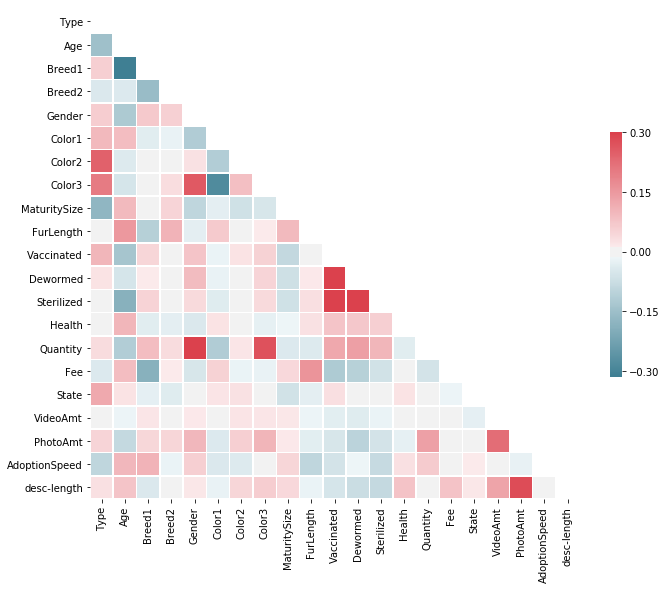

In [12]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

After checking the correlations with our target it looks as if there are no significant correlations between our target and the other features.

## Field Analysis

### Target - Adoption Speed

Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way: 
0. Pet was adopted on the same day as it was listed. 
1. Pet was adopted between 1 and 7 days (1st week) after being listed. 
2. Pet was adopted between 8 and 30 days (1st month) after being listed. 
3. Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. 
4. No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [ ]:
target = df['AdoptionSpeed']

In [ ]:
target.value_counts().sort_index().plot('barh', color='orange')
plt.title('Count of AdoptionSpeed')

In [ ]:
target.value_counts().sort_index()

### Names

In [ ]:
print('Most popular names with matching AdoptionSpeed')
for name in df['Name'].value_counts().index[:10]:
    print(name)
    print(df.loc[df['Name'] == name, 'AdoptionSpeed'].value_counts().sort_index())
    print('\n')

In [ ]:
df['Name'] = df['Name'].fillna('Unnamed')
df['Unnamed'] = 0
df.loc[df['Name'] == 'Unnamed', 'Unnamed'] = 1

In [ ]:
print('% of Unnamed pets: '+str(df['Unnamed'].sum()*100/df['Unnamed'].shape[0])+'%')

In [ ]:
pd.crosstab(df['Unnamed'], df['AdoptionSpeed'], normalize='index')

It looks as if unnamed pets have a slightly higher chance of not being adopted. Maybe this can be further analyzed in a feature

## Base Model

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2)

My Base Model (a LinearRegression) only takes numerical features. I have to either change scales or just drop them. For now I will drop my categorial features.

In [ ]:
drop_feat_list = ['AdoptionSpeed', 'Name', 'RescuerID', 'Description', 'PetID']

feature_list = list(df.columns)
feature_list = [x for x in feature_list if x not in drop_feat_list]

X = df_train[feature_list]
y = df_train['AdoptionSpeed'].values

In [ ]:
grid = {'penalty': ['l1','l2'], 'multi_class': ['auto'], 'solver':['liblinear','saga']}
lm = LogisticRegression(max_iter=1000)

kappa_scorer = make_scorer(squared_cohen_kappa)

lm_cv=GridSearchCV(lm,grid, scoring=kappa_scorer,cv=3)
lm_cv.fit(X,y)

print("tuned hpyerparameters :(best parameters) ",lm_cv.best_params_)
print("accuracy :",lm_cv.best_score_)

In [ ]:
df_test['lm_pred'] = lm_cv.predict(df_test[feature_list])
lm_kappa = squared_cohen_kappa(df_test['AdoptionSpeed'], df_test['lm_pred'])
print('Model tested! Squared Cohen Kappa: '+str(lm_kappa))

## LightLGBM Classifier

In [ ]:
lgbm = LGBMClassifier(objective='multiclass', random_state=5)

lgbm.fit(X,y)
df_test['lgbm_pred'] = lgbm.predict(df_test[feature_list])

lgbm_kappa = squared_cohen_kappa(df_test['AdoptionSpeed'], df_test['lgbm_pred'])

print('Model tested! Squared Cohen Kappa: '+str(lgbm_kappa))


In [ ]:
grid = {'learning_rate':[0.1,0.001,0.003,0.0005],'max_bin':[100,255,400,500],'num_iterations':[50,100,150,200,300,500]}
lgbm = LGBMClassifier(objective='multiclass', random_state=5)

lgbm_cv=GridSearchCV(lgbm,grid, scoring=kappa_scorer,cv=3)
lgbm_cv.fit(X,y)

print("tuned hpyerparameters :(best parameters) ",lgbm_cv.best_params_)
print("accuracy :",lgbm_cv.best_score_)